In [1122]:
import math
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(127)

%run ./DiffusionLunarKF.ipynb

**Constants used in Covariance Matricies**

In [1123]:
# variables
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5
dt = 7
sigma_uere = 0 # can't find a value for this

**Time Transfer Process Covariance (Q)**

The values for h_0, h_m1, and h_m2 were found from DOI - 10.1007/s10291-015-0480-2 in Table 2

These were quite literally the only sources I was able to find on these values.

In [1124]:
#Values from random table in Source 31
# h_0 = 1.4*(10**(-22))
# h_m1 = 2.3*(10**(-26))
# h_m2 = 3.3*(10**(-31))


#Values from sample clocks in Source 30
h_0 = 1.8*(10**(-21))
h_m1 = 6.492*(10**(-22))
h_m2 = 1.37*(10**(-24))

pi = math.pi

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

Q = (c**2)*np.array([[e1,e2],[e2,e3]])

if __name__ == '__main__':
    print(Q)

[[0.00656212 0.00087641]
 [0.00087641 0.00015093]]


**Time Transfer GPS Measurement Covariance (R)**

Constants were given throughout time transfer paper, however resulting values seem off. Mainly, the psuedorange-rate residual's have a covariance on the order of 10^9. As such we sometimes opt to use R = I

Note: The size of R changes depending on how many satellites are visible to the station, as such we define R as a funcrion of the number of visible satellites (N).

In [1125]:
s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)


R = lambda N :np.block([[pr_var*np.eye(N,N),np.zeros((N,N))],[np.zeros((N,N)),prr_var*np.eye(N,N)]])
print(R(2))
# R = lambda N :9*np.eye(2*N,2*N)

[[24.40369964  0.          0.          0.        ]
 [ 0.         24.40369964  0.          0.        ]
 [ 0.          0.          0.20383392  0.        ]
 [ 0.          0.          0.          0.20383392]]


In [1126]:
H_cf = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
H_20x10 = np.zeros((20, 10))
for k in range(0, 20, 4):
    H_20x10[k:k+4, k//2:k//2+2] = H_cf

R_20x20 = np.kron(np.eye(5),R(2))
measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)

Q_10x10 = np.kron(np.eye(5),Q)
#Process Noise
procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)


In [1127]:
sigma_j = 10**(-16)
#paper varies from s_j = 10^{-14} to 10^{-6}

**Filter Simulation**

Since the Coavariances are set above, we simply specify the diffusion weight matrix and the broadcast time matrix as well as the initial estimates and covariances for each station. Here is also where we create and update(with process noise) our true values for time, bias, and drift.

Right now we assume the weights are divided equally and our network topology is 5 nodes aranged in a plus with node 0 being the center

In [1128]:
def compute_mse(predictions, truth, n):
  mse = np.zeros((2,)) # array to store the MSE for bias and drift
  for i in range(n):
    mse[0] += np.mean((predictions[:, i, 0] - truth[:, i, 0])**2) # compute mse for bias
    mse[1] += np.mean((predictions[:, i, 1] - truth[:, n + i])**2) # compute mse for drift

  # normalize and return the mse value
  mse /= n
  return mse

20448.052585885118
254.19576164043366
86.70527017719604
92.60026267061438
103.37262507654616
105.44919931123655
102.63788116039555
98.37800566348731
94.18833081308148
90.581895356934
87.63813787612307
85.28395880320433
83.40847489592923
81.90632794747795
80.69128937910905
79.6981582924253
78.88017238691582
78.20489817583203
77.64992924491172
77.19908551988402
76.83948364226593
76.55960657417126
76.3483006716475
76.19449222079996
76.08735881594617
76.01670551888306
75.97335538501801
75.94943913593069
75.93853700148213
75.93567529278704
75.93720868102815
75.94062979805013
75.94434628836206
75.94745738910433
75.94955180239337
75.95053881713
75.95051675525472
75.94967731042765
75.94824107495472
75.94641807993276
75.94438698445903
75.94228715604206
75.94021889252768
75.93824816192641
75.93641329893565
75.93473199757929
75.93320764112225
75.93183451643527
75.93060179506043
75.92949636317452
75.9285046828897
75.92761390079302
75.92681241191116
75.92609005798585
75.92543810151915
75.9248490795

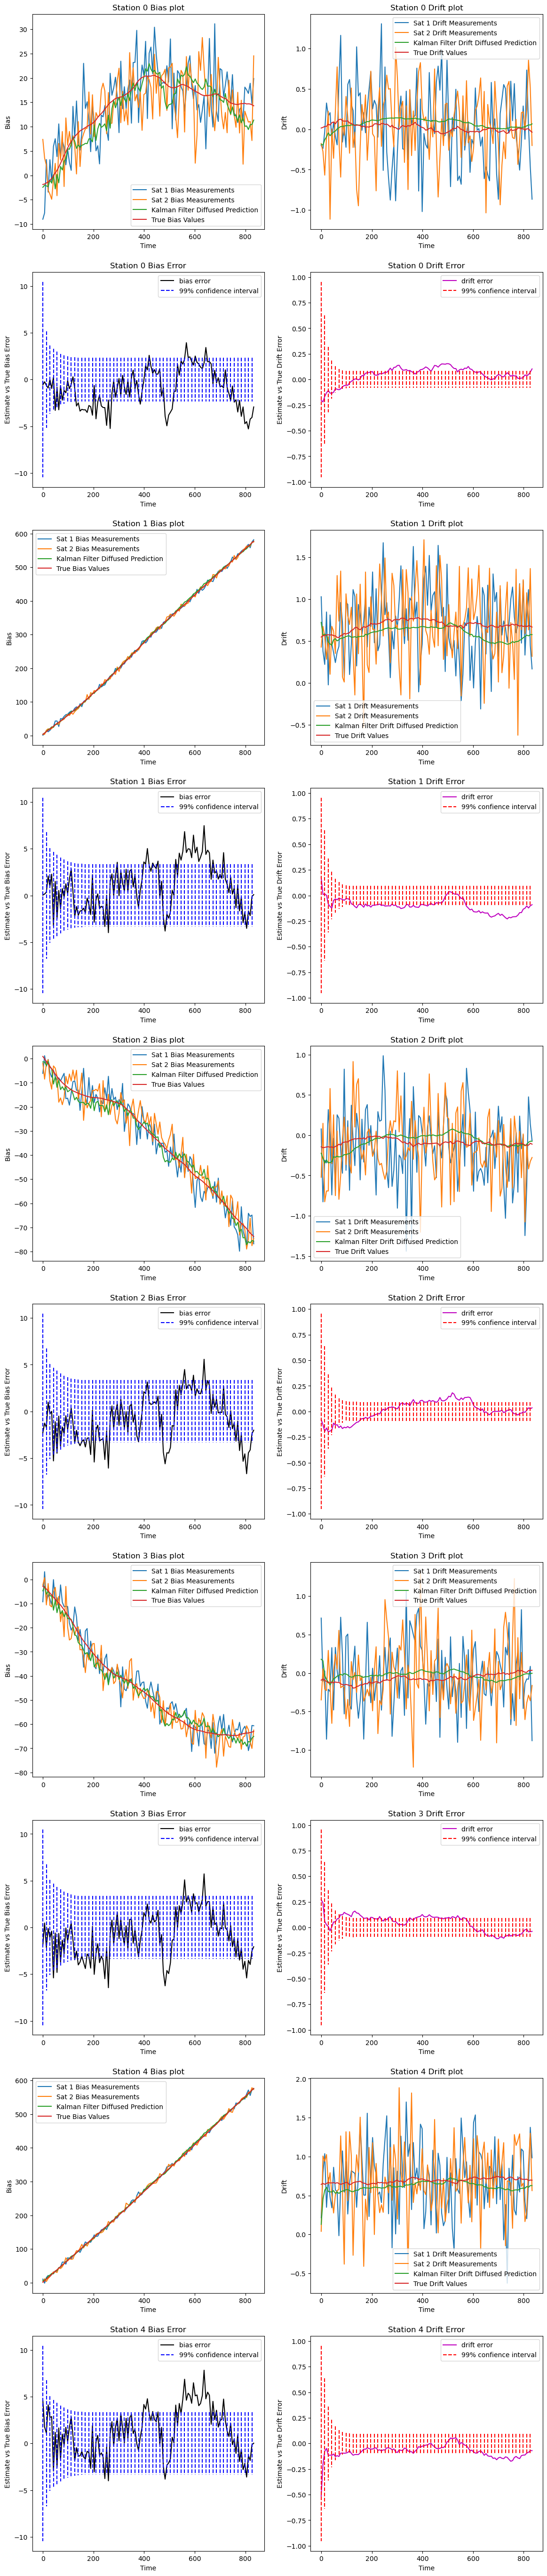

In [1129]:
def example():
    C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
    D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
    n = len(C[0])

    iterations = 120

    T_g = 0
    true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
    true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
    # true_drifts = np.array([[0 for _ in range(n)]]).T


    def get_station_truth(x,id):
        return np.array([[x[2*id][0]],[x[2*id+1][0]]])

    x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))
    # random initial estimates for each node

    x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
    # x0 = [np.array([[0],[0]]) for _ in range(n)]

    P = [100*np.copy(R(1)) for _ in range(n)]

    P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

    truth = np.zeros((iterations,2*n,1))
    measurements = np.zeros((iterations,4*n,1))


    predictions = np.zeros((iterations,n,2,1))
    updated_pred = np.zeros((iterations,n,2,1))
    diffused_pred = np.zeros((iterations,n,2,1))
    errors = np.zeros((iterations,n,2,1))
    P_hist = np.zeros((iterations,n,2,2))
    
    full_P_hist = np.zeros((iterations,2*n,2*n))

    stations = [Station(i) for i in range(n)]

    filter_initialize(stations,D,x0,P)


    F = np.array([[1,dt],[0,1]])
    F_full = np.kron(np.eye(n),F)

    for i in range(iterations):
        #This is our new truth
        x = F_full@x + procc_noise()
        
        truth[i] = x
        measurements[i] = (H_20x10@x) + measure_noise()

        T_g += dt

        true_biases = [x[::2][i]/c for i in range(n)]
        true_drifts = [x[1::2][i]/c for i in range(n)]

        z = measurements[i]

        gps_measurements = [z[4*k:4*(k+1)] for k in range(n)]
        if i == 0:
             time_x,gps_x,time_ests, cov_ests = diffusion_filter_iteration(
                 stations,Q,R,C,gps_measurements, None,None,true_biases,true_drifts,T_g,dt,sigma_j)
        else:
             time_x,gps_x,time_ests,cov_ests = diffusion_filter_iteration(
                 stations,Q,R,C,gps_measurements, time_ests,cov_ests,true_biases,true_drifts,T_g,dt,sigma_j)

        cross_link_time = [stn.local_time['Bp']-stn.local_time['n'] for stn in stations]
        P_prev = get_full_diff_cov(C,[station.P for station in stations],[2 for _ in range(n)],P_prev,stations,F,R,Q,sigma_j,cross_link_time)     
        full_P_hist[i] = P_prev
        print(sum([P_prev[i,i] for i in range(2*n)]))
        errors[i] = np.array([station.x - get_station_truth(x,station.id) for station in stations])
        predictions[i] = np.array(time_x)
        updated_pred[i] = np.array(gps_x)
        diffused_pred[i] = np.array([stn.x for stn in stations])
        P_hist[i] = np.array([station.P for station in stations])


    #Number of stations whose plots we are looking at
    k = [0,1,2,3,4]

    num_rows = 2*len(k)
    fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
    t_hist = np.arange(0, dt*iterations, dt)
    for inx,i in enumerate(k):
        #20 measurements, 2 for each node
        axs[2*inx][0].plot(t_hist,[x[4*i][0] for x in measurements], label = 'Sat 1 Bias Measurements')
        axs[2*inx][0].plot(t_hist,[x[4*i+1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
        # axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
        # axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in updated_pred], label = 'Kalman Filter Bias Updated Prediction')
        axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in diffused_pred], label = 'Kalman Filter Diffused Prediction')
        axs[2*inx][0].plot(t_hist,[x[2*i][0] for x in truth], label = 'True Bias Values')
        axs[2*inx][0].set_title("Station "+str(i)+" Bias plot")
        axs[2*inx][0].set_xlabel("Time")
        axs[2*inx][0].set_ylabel("Bias")
        axs[2*inx][0].legend()

        axs[2*inx][1].plot(t_hist,[x[4*i+2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
        axs[2*inx][1].plot(t_hist,[x[4*i+3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
        # axs[2*inx][1].plot(t_hist,[x[i][1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
        # axs[2*inx][1].plot(t_hist,[x[i][1][0] for x in updated_pred], label = 'Kalman Filter Drift Updated Prediction')
        axs[2*inx][1].plot(t_hist,[x[i][1][0] for x in diffused_pred], label = 'Kalman Filter Drift Diffused Prediction')
        axs[2*inx][1].plot(t_hist,[x[2*i + 1][0] for x in truth], label = 'True Drift Values')
        axs[2*inx][1].set_title("Station "+str(i)+" Drift plot")
        axs[2*inx][1].set_xlabel("Time")
        axs[2*inx][1].set_ylabel("Drift")
        axs[2*inx][1].legend()

        step = max(1,iterations//60)
        vertical_markers = np.arange(0, dt*iterations, dt*step)

        axs[2*inx+1][0].plot(t_hist, errors[:, i,0,0], 'k', label = "bias error")

        axs[2*inx+1][0].plot(np.vstack([vertical_markers[0], vertical_markers[0]]), 
                             np.vstack([3*np.sqrt(P_hist[0, i,0,0]), -3*np.sqrt(P_hist[0, i, 0,0])]), 
                             'b--', label = "99% confidence interval")
        
        axs[2*inx+1][0].plot(np.vstack([vertical_markers[1:], vertical_markers[1:]]), 
                             np.vstack([3*np.sqrt(P_hist[1:(59*step + 1):step, i,0,0]), -3*np.sqrt(P_hist[1:(59*step + 1):step, i, 0,0])]), 'b--')
        
        axs[2*inx+1][1].plot(t_hist, errors[:, i,1,0], 'm', label = "drift error")

        axs[2*inx+1][1].plot(np.vstack([vertical_markers[0], vertical_markers[0]]), 
                             np.vstack([3*np.sqrt(P_hist[0, i,1,1]), -3*np.sqrt(P_hist[0, i, 1,1])]), 
                             'r--', label = "99% confience interval")
        
        axs[2*inx+1][1].plot(np.vstack([vertical_markers[1:], vertical_markers[1:]]), 
                             np.vstack([3*np.sqrt(P_hist[1:(59*step + 1):step, i,1,1]), -3*np.sqrt(P_hist[1:(59*step + 1):step, i, 1,1])]), 'r--')
        
        axs[2*inx+1][0].legend()
        axs[2*inx+1][0].set_title("Station "+str(i)+" Bias Error")
        axs[2*inx+1][0].set_xlabel("Time")
        axs[2*inx+1][0].set_ylabel("Estimate vs True Bias Error")
        axs[2*inx+1][1].legend()
        axs[2*inx+1][1].set_title("Station "+str(i)+" Drift Error")
        axs[2*inx+1][1].set_xlabel("Time")
        axs[2*inx+1][1].set_ylabel("Estimate vs True Drift Error")

    plt.show()

if __name__ == '__main__':
    example()
